In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 13

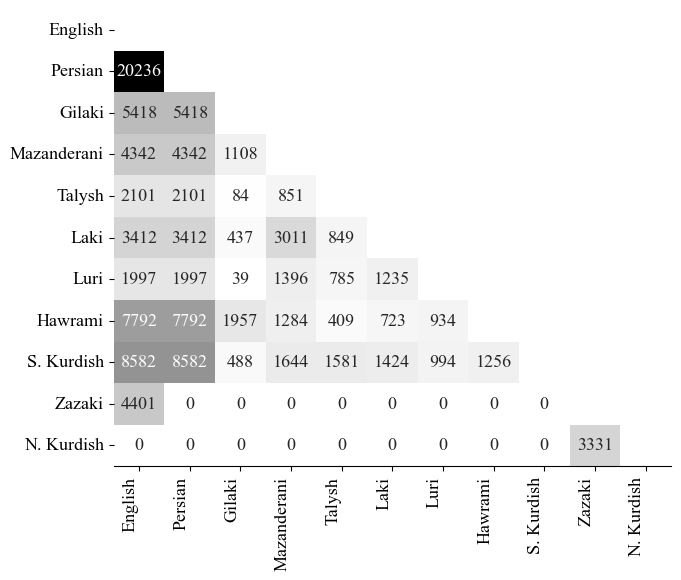

In [55]:
file_path = "/Users/sina/Library/CloudStorage/GoogleDrive-sinaahmadi.yae@gmail.com/My Drive/Documentation/DOLMA/MT-benchmarks/common_sentences.tsv"
df = pd.read_csv(file_path, sep="\t")

languages = df.columns.tolist()
languages = ['English', 'Persian', 'Gilaki', 'Mazanderani', 'Talysh', 'Laki', 'Luri', 'Hawrami', 'S. Kurdish', 'Zazaki', 'N. Kurdish']
languages = ['English', 'Persian', 'Gilaki', 'Mazanderani', 'Talysh', 'Laki', 'Luri', 'Hawrami', 'S. Kurdish', 'Zazaki', 'N. Kurdish']

coverage_matrix = {lang: [0] * len(languages) for lang in languages}


for i, lang1 in enumerate(languages):
	for j, lang2 in enumerate(languages):
		if lang1 in df and lang2 in df:
			if lang1 != lang2: # Exclude diagonal
				coverage_matrix[lang1][j] = ((df[lang1].notna()) & (df[lang2].notna())).sum()
		else:
			coverage_matrix[lang1][j] = 0

# dict_keys(['English', 'Persian', 'Gilaki', 'Mazanderani', 'Talysh', 'Laki', 'Luri', 'Hawrami', 'S. Kurdish'])
coverage_matrix["Zazaki"][-1] = 3331
coverage_matrix["English"][-2] = 3331+1070

coverage_df = pd.DataFrame(coverage_matrix, index=languages)

mask = np.triu(np.ones_like(coverage_df, dtype=bool))

plt.figure(figsize=(7, 6)) 
sns.heatmap(coverage_df, annot=True, fmt="d", cmap="binary", xticklabels=languages, yticklabels=languages, mask=mask, cbar=False) 
plt.xticks(rotation=90, ha='right') # ha='right' helps with alignment
plt.tight_layout()  # Added to ensure all labels are visible
ax = plt.gca()  # Get the current axis
ax.spines['top'].set_visible(False)    # Hide the top spine
ax.spines['right'].set_visible(False)  # Hide the right spine
ax.spines['bottom'].set_visible(True)  # Show the bottom spine
ax.spines['left'].set_visible(False)    # Show the left spine
plt.savefig("/Users/sina/Library/CloudStorage/GoogleDrive-sinaahmadi.yae@gmail.com/My Drive/Documentation/DOLMA/MT-benchmarks/common_heatplot.pdf", bbox_inches='tight')
plt.show()


### Visualize the datasets and splits

In [85]:
datasets = {
	"BQI": {"val": "BQI-val.tsv", "test": "BQI-test.tsv"},
	"TLY": {"val": "TLY-val.tsv", "test": "TLY-test.tsv"},
	"GLK": {"val": "GLK-val.tsv", "test": "GLK-test.tsv", "train": "GLK-train.tsv"},
	"HAC": {"val": "HAC-val.tsv", "test": "HAC-test.tsv", "train": "HAC-train.tsv"},
	"LKI": {"val": "LKI-val.tsv", "test": "LKI-test.tsv", "train": "LKI-train.tsv"},
	"MZN": {"val": "MZN-val.tsv", "test": "MZN-test.tsv", "train": "MZN-train.tsv"},
	"SDH": {"val": "SDH-val.tsv", "test": "SDH-test.tsv", "train": "SDH-train.tsv"},
	"ZZA": {"val": "ZZA-val.tsv", "test": "ZZA-test.tsv", "train": "ZZA-train.tsv"}
}

lang_dicts = dict()
for language in datasets:
	lang_dicts.update({language: {}})
	for split in datasets[language]:
		with open("/Users/sina/Library/CloudStorage/GoogleDrive-sinaahmadi.yae@gmail.com/My Drive/Documentation/DOLMA/MT-benchmarks/datasets/" + datasets[language][split], "r") as f:
			split_data = f.read().splitlines()[1:]

		lang_dicts[language].update({split: {"dialects": {}, "orthographies": {}, "translators": {}}})

		# process the split
		for i in split_data:		
			if language != "ZZA" and split != "test":
				dialect = i.split("\t")[3]
				orthography = i.split("\t")[5]
				translator = i.split("\t")[6]
			else:
				dialect = i.split("\t")[3]
				orthography = i.split("\t")[5]
				translator = i.split("\t")[6]

			if dialect in lang_dicts[language][split]["dialects"]:
				lang_dicts[language][split]["dialects"][dialect] += 1
			else:
				lang_dicts[language][split]["dialects"].update({dialect: 1})

			if orthography in lang_dicts[language][split]["orthographies"]:
				lang_dicts[language][split]["orthographies"][orthography] += 1
			else:
				lang_dicts[language][split]["orthographies"].update({orthography: 1})
			
			if translator in lang_dicts[language][split]["translators"]:
				lang_dicts[language][split]["translators"][translator] += 1
			else:
				lang_dicts[language][split]["translators"].update({translator: 1})

with open("/Users/sina/Library/CloudStorage/GoogleDrive-sinaahmadi.yae@gmail.com/My Drive/Documentation/DOLMA/MT-benchmarks/datasets_stats.json", "w") as f:
	json.dump(lang_dicts, f, indent=4, sort_keys=True)

In [102]:
import json

def generate_combined_plot(lang_data, lang_code):
	"""Generate a TikZ plot with side-by-side stacked bars."""
	tikz = [
		"\\begin{figure}[ht]",
		"\\centering",
		"\\begin{tikzpicture}",
		"\\pgfplotsset{width=12cm, height=7cm}"
	]
	
	tikz.extend([
		"\\begin{axis}[",
		"    ybar stacked,", 
		"    bar width=12pt,",
		"    enlarge x limits=0.2,",
		"    legend style={at={(1.05,0.5)}, anchor=west},",
		"    ylabel={Number of sentences},",
		"    symbolic x coords={test,val,train},",
		"    xtick=data,",
		f"    title={{{lang_code} Distribution}},",
		"    ymin=0,",
		"    legend columns=1,",
		"    bar shift=-6pt",  
		"]",
		""
	])

	dialects = sorted(list(set(d for split in ['train', 'test', 'val'] 
					if split in lang_data 
					for d in lang_data[split].get('dialects', {}).keys())))

	for i, dialect in enumerate(dialects):
		coords = []
		for split in ['test', 'val', 'train']:
			count = lang_data[split]['dialects'].get(dialect, 0) if split in lang_data else 0
			coords.append(f"({split},{count})")
		color = ["red!70!white", "green!70!white"][i % 2]
		tikz.append(f"\\addplot[fill={color}] coordinates {{{' '.join(coords)}}};")
		tikz.append(f"\\addlegendentry{{D: {dialect}}}")

	tikz.extend([
		"\\end{axis}",
		"\\begin{axis}[",
		"    ybar stacked,",
		"    bar width=12pt,",
		"    enlarge x limits=0.2,",
		"    hide axis,", 
		"    symbolic x coords={test,val,train},",
		"    axis on top,",
		"    ymin=0,",
		"    bar shift=6pt",  
		"]"
	])
	
	patterns = {
		"Vrg": "horizontal lines",
		"Sarkhat": "north west lines",
		"Other": "dots"
	}
	
	orthos = sorted(list(set(o for split in ['train', 'test', 'val'] 
				   if split in lang_data 
				   for o in lang_data[split].get('orthographies', {}).keys())))

	for ortho in orthos:
		coords = []
		for split in ['test', 'val', 'train']:
			count = lang_data[split]['orthographies'].get(ortho, 0) if split in lang_data else 0
			coords.append(f"({split},{count})")
		pattern = patterns.get(ortho, "dots")
		tikz.append(f"\\addplot[pattern={pattern}] coordinates {{{' '.join(coords)}}};")
		tikz.append(f"\\addlegendentry{{O: {ortho}}}")

	tikz.extend([
		"\\end{axis}",
		"\\end{tikzpicture}",
		f"\\caption{{Distribution of dialects and orthographies in {lang_code} dataset}}",
		f"\\label{{fig:{lang_code.lower()}_dist}}",
		"\\end{figure}"
	])
	
	return "\n".join(tikz)

def main():
	with open("/Users/sina/Library/CloudStorage/GoogleDrive-sinaahmadi.yae@gmail.com/My Drive/Documentation/DOLMA/MT-benchmarks/datasets_stats.json", "r", encoding="utf-8") as f:
		data = json.load(f)
	
	for lang_code in data:
		preamble = [
			"% Required packages:",
			"% \\usepackage{pgfplots}",
			"% \\usetikzlibrary{patterns}",
			"% \\pgfplotsset{compat=1.16}",
			""
		]
		
		plot = generate_combined_plot(data[lang_code], lang_code)
		
		with open(f"/Users/sina/Library/CloudStorage/GoogleDrive-sinaahmadi.yae@gmail.com/My Drive/Documentation/DOLMA/MT-benchmarks/visualization/{lang_code}_plot.tex", "w", encoding="utf-8") as f:
			f.write("\n".join(preamble) + "\n" + plot)

if __name__ == "__main__":
	main()